# Выбор локации для скважины

**Описание целей и задачи проекта**

Нефтедобывающей комании «ГлавРосГосНефть» требуется построить модель для определения региона, где добыча принесёт наибольшую прибыль при наименьших рисках.

При разведке региона исследуют 500 точек, из которых с помощью машинного обучения необходимо выбирать 200 лучших для разработки.

Бюджет на разработку скважин в регионе — 10 млрд рублей.

При нынешних ценах один баррель сырья приносит 450 рублей дохода. Доход с каждой единицы продукта составляет 450 тыс. рублей, поскольку объём указан в тысячах баррелей.

После оценки рисков нужно оставить те регионы, в которых вероятность убытков меньше 2.5%. Среди них выбрать регион с наибольшей средней прибылью.

**Описание данных**

В распоряжении пробы нефти в трёх регионах: качество нефти и объём её запасов.


**План работы**
- загрузка и подготовка данных
- построение модели линейной регрессии для предсказания объёма запасов в новых скважинах
    - разбить данные на обучающую и валидационную выборки в соотношении 75:25
    - обучить модель и сделать предсказания на валидационной выборке
    - сохранить предсказания и правильные ответы на валидационной выборке
    - визуализировать средний запас предсказанного сырья и RMSE модели
    - проанализировать результаты
- рассчитать достаточный объём сырья для безубыточной разработки новой скважины, сравнить полученный объём сырья со средним запасом в каждом регионе и написать выводы
- рассчитать прибыль для полученного объёма сырья
- посчитать риски и прибыль для каждого региона
    - применить технику Bootstrap с 1000 выборок, чтобы найти распределение прибыли
    - найти среднюю прибыль, 95%-й доверительный интервал и риск убытков
    - написать выводы и предложить регион для разработки скважин



## Загрузка и подготовка данных

In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

/Users/refresh/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# константы
QUANTITY_RESEARCH = 500 # при разведке региона исследуют 500 точек
MODEL_RESEARCH = 200 # количество точек для разработки
REGION_BUDGET = 10000000000 # бюджет на разработку скважин в регионе
INCOME_ONE_UNIT = 450000 # доход с одной единица продукции
PROBABILITY_MIN_LOSS = 2.5 # минимальный порог убытков (%)

In [3]:
# читаем данные спомощью try..except и read_csv
try:
    geo_1= pd.read_csv('/datasets/geo_data_0.csv')
    geo_2= pd.read_csv('/datasets/geo_data_1.csv')
    geo_3= pd.read_csv('/datasets/geo_data_2.csv')
except:
    geo_1 = pd.read_csv('/Users/refresh/Downloads/geo_data_0.csv')
    geo_2 = pd.read_csv('/Users/refresh/Downloads/geo_data_1.csv')
    geo_3 = pd.read_csv('/Users/refresh/Downloads/geo_data_2.csv')

In [4]:
pth1 = '/datasets/geo_data_0.csv'
pth2 = '/Users/refresh/Downloads/geo_data_0.csv'

pth3 = '/datasets/geo_data_1.csv'
pth4 = '/Users/refresh/Downloads/geo_data_1.csv'

pth5 = '/datasets/geo_data_2.csv'
pth6 = '/Users/refresh/Downloads/geo_data_2.csv'

if os.path.exists(pth1):
    geo_1 = pd.read_csv(pth1)
elif os.path.exists(pth2):
    geo_1 = pd.read_csv(pth2)
else:
    print('Something is wrong')
    
if os.path.exists(pth3):
    geo_2 = pd.read_csv(pth3)
elif os.path.exists(pth4):
    geo_2 = pd.read_csv(pth4)
else:
    print('Something is wrong')
    
if os.path.exists(pth5):
    geo_3 = pd.read_csv(pth5)
elif os.path.exists(pth6):
    geo_3 = pd.read_csv(pth6)
else:
    print('Something is wrong')

Посмотрим данные во всех трёх таблицах.

#### Первая база

**Что необходимо сделать на этом этапе:**

- [x] ознакомиться со всеми данными подробнее
- [x] проверить дубликаты
- [x] соединить таблицы в одну, для обучения модели и удобства работы
- [x] написать выводы

--------------------------------------------
Инфориация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------
5 случайных строк


,id,f0,f1,f2,product
14595,00vhM,0.226262,-0.339984,0.940113,86.988250
6177,qeKqH,1.027142,-0.419617,4.741997,163.721780
74509,2WZoK,0.540765,-0.437584,1.744742,78.986954
96101,Wdunf,0.780955,0.613177,3.609559,103.459844
79944,j9mzv,0.014423,0.441211,5.058077,143.244399


--------------------------------------------
Описание данных


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


--------------------------------------------
Коэффициент корреляции


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


--------------------------------------------


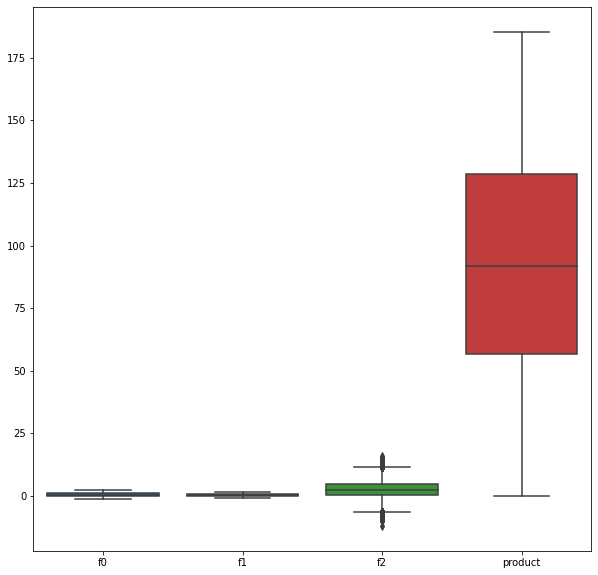

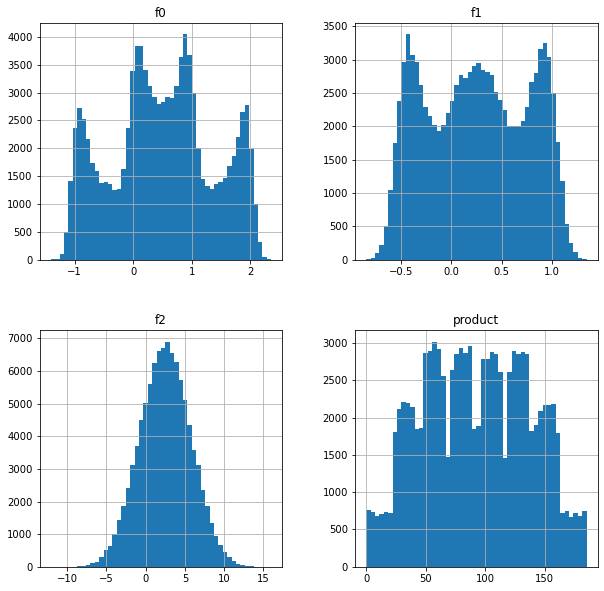

In [5]:
# функция для ознакомления с данными
def description(data):
    print('--------------------------------------------')
    print('Инфориация')
    data.info()
    print('--------------------------------------------')
    print('5 случайных строк')
    display(data.sample(5))
    print('--------------------------------------------')
    print('Описание данных')
    display(data.describe())
    print('--------------------------------------------')
    print('Коэффициент корреляции')
    display(data.corr())
    print('--------------------------------------------')
    plt.figure(figsize=(10,10))
    sb.boxplot(data=data)
    data.hist(bins=50, figsize=(10, 10));
# смотрим данные
description(geo_1)

В признаке f2 есть выбросы, отбросим экстримальные значения

In [6]:
print('1% квантиль', geo_1['f2'].quantile(0.01))
print('99% квантиль', geo_1['f2'].quantile(0.99))
len_1 = len(geo_1)
geo_1 = geo_1[(geo_1['f2'] > geo_1['f2'].quantile(0.01)) & (geo_1['f2'] < geo_1['f2'].quantile(0.99))]
print('удалено', len_1 - len(geo_1), 'строк')


1% квантиль -4.9731962401024425
99% квантиль 9.969349073218709
удалено 2000 строк


#### Вторая база

--------------------------------------------
Инфориация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------
5 случайных строк


,id,f0,f1,f2,product
22757,ueHr9,-7.206278,-8.465586,4.998128,137.945408
49626,J3Liu,-9.664692,-9.173469,0.996508,30.132364
85492,cb0ML,15.993197,-3.531228,0.996494,26.953261
30933,z7Lu9,-8.653489,-8.134084,2.004064,57.085625
27894,erWR9,-10.190721,-4.557251,-0.000185,3.179103


--------------------------------------------
Описание данных


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


--------------------------------------------
Коэффициент корреляции


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


--------------------------------------------


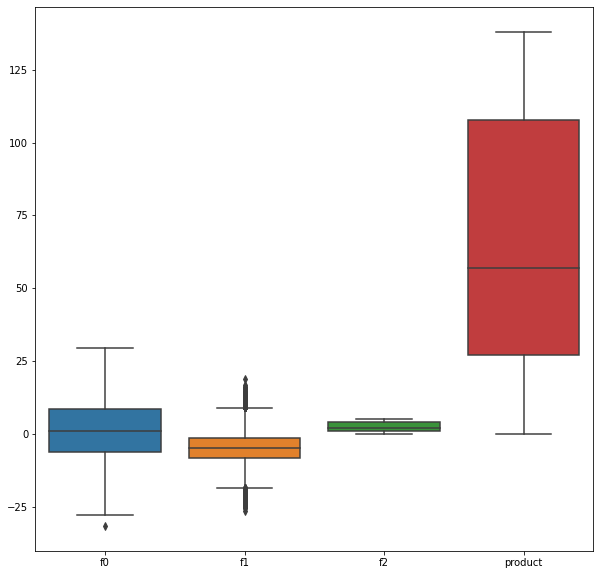

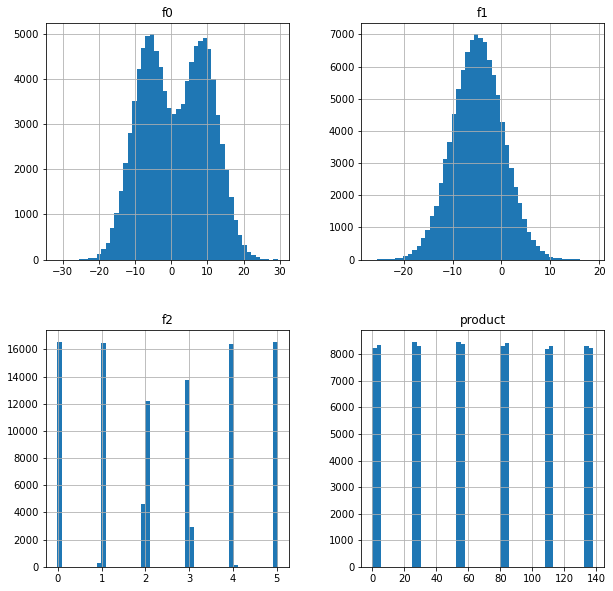

In [7]:
# смотрим данные
description(geo_2)

В признаке f1 есть выбросы, отбросим экстримальные значения

In [8]:
print('1% квантиль', geo_2['f1'].quantile(0.01))
print('99% квантиль', geo_2['f1'].quantile(0.99))
len_1 = len(geo_2)
geo_2 = geo_2[(geo_2['f1'] > geo_2['f1'].quantile(0.01)) & (geo_2['f1'] < geo_2['f1'].quantile(0.99))]
print('удалено', len_1 - len(geo_2), 'строк')


1% квантиль -16.584109073677695
99% квантиль 7.139352079223989
удалено 2000 строк


#### Третья база

--------------------------------------------
Инфориация
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
--------------------------------------------
5 случайных строк


,id,f0,f1,f2,product
6857,afKJN,-0.427470,-0.964467,-2.053632,30.542172
25018,2Srrl,-1.158057,-1.784672,4.842136,158.960514
74258,P2Q2i,0.386498,0.831373,4.946633,95.202113
45734,hYzgv,0.198543,-0.080674,6.118996,115.757067
62223,ENUYU,1.357333,0.965561,-0.388560,80.986873


--------------------------------------------
Описание данных


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


--------------------------------------------
Коэффициент корреляции


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


--------------------------------------------


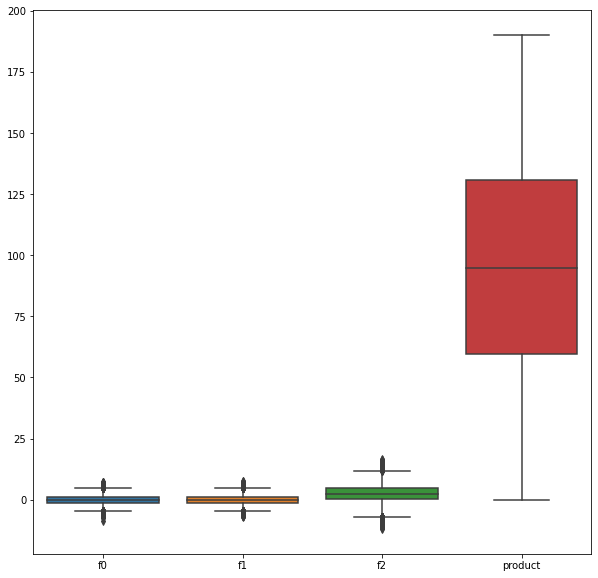

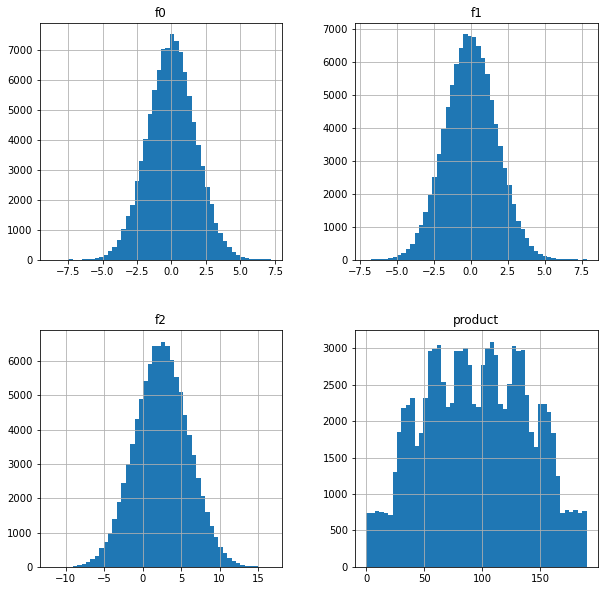

In [9]:
# смотрим данные
description(geo_3)

Три таблицы по 100000 строк, пропусков нет. Таблицы содержат информацию:
 - id — уникальный идентификатор скважины;
 - f0, f1, f2 — три признака точек;
 - product — объём запасов в скважине (тыс. баррелей).

В признаках есть выбросы, отбросим экстримальные значения

In [10]:
len_1 = len(geo_3)
for i in ['f0', 'f1', 'f2']:
    q1 = geo_3[i].quantile(0.01)
    q2 = geo_3[i].quantile(0.99)
    print('1% квантиль', i, q1)
    print('99% квантиль', i, q2)
    print('---------------------------------------')
    geo_3 = geo_3[(geo_3[i] > geo_3[i].quantile(0.01)) & (geo_3[i] < geo_3[i].quantile(0.99))]

print('удалено', len_1 - len(geo_3), 'строк')

1% квантиль f0 -4.021439783588339
99% квантиль f0 4.057782812192161
---------------------------------------
1% квантиль f1 -4.006062829832023
99% квантиль f1 4.014018720543447
---------------------------------------
1% квантиль f2 -5.50866809623379
99% квантиль f2 10.495965776351479
---------------------------------------
удалено 5882 строк


Т к в столбце 'id' используются заглавные буквы, посмотри нет ли дубликатов.

In [11]:
# соединим таблицы, понизим регистр и проверим количество дубликатов
for i in [geo_1, geo_2, geo_3]:
    i['id'] = i['id'].str.lower()
    print('дубликатов', i.duplicated().sum())
    print(i['id'].value_counts())
    print('-------------------------------')

дубликатов 0
rsutw    2
stkqq    2
hnjbu    2
zogg5    2
qw6lh    2
        ..
ocoua    1
sjkc8    1
n8mr5    1
hpkod    1
1cwhh    1
Name: id, Length: 97893, dtype: int64
-------------------------------
дубликатов 0
ixqfp    2
0vyhp    2
xmyqp    2
ionyl    2
uptna    2
        ..
wztrl    1
hjq3a    1
7usup    1
tqk0w    1
relb0    1
Name: id, Length: 97890, dtype: int64
-------------------------------
дубликатов 0
iyyyk    2
20w2a    2
h84jl    2
x12al    2
ifogf    2
        ..
j4qbk    1
kmlmi    1
lxcff    1
8wckz    1
v9kwn    1
Name: id, Length: 94032, dtype: int64
-------------------------------


Неявные дубликаты есть, удалим их.

In [12]:
for i in [geo_1, geo_2, geo_3]:
    len_befor = len(i)
    i['id'] = i['id'].drop_duplicates()
    i = i.dropna().reset_index(drop=True)
    len_after = len(i)
    print('В таблице', 'удалено', len_befor - len_after, 'дубликатов')

В таблице удалено 107 дубликатов
В таблице удалено 110 дубликатов
В таблице удалено 86 дубликатов


Неявные дубликаты удалены, их количесво составляет около 1%.

**Выводы**

- в данных нет пропусков
- дубликатов удалены
- признаки распределены в большенстве случаев нормально, за исключением f2 во второй таблице - там признак ведет себя похоже на целевой признак и корреляция между ними почти линейная
- в данных наблюдались выбросы, мы их исключили
- данные подготовлены для анализа

## Обучение и проверка модели

**Что необходимо сделать на этом этапе:**

- [x] выделить признаки и целевой признак для каждого региона
- [x] подготовить признаки для модели
- [x] разбить данные на две тренировочную и валидационную выборки
- [x] обучить модели
- [x] проверить модели на адекватность
- [x] вывести на экран средний запас предсказанного сырья и RMSE модели
- [x] написать выводы


Используем StandardScaler для преобразования признаков, т к по гистаграммам их распределение похоже на нормальное в большенстве случаев.

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b> пробовал SGDRegressor и GridSearchCV, результат совпадает
</div>

```python
from sklearn.linear_model import SGDRegressor

linear_regression_model = SGDRegressor(tol=.0001, eta0=.01) 
linear_regression_model.fit(features_geo_1_train, target_geo_1_train)
predictions_1 = linear_regression_model.predict(features_geo_1_valid)
mse_1 = mean_squared_error(target_geo_1_valid, prediction_1)
print('MRSE =', round(mse_1 ** 0.5, 2))

Средний запас предсказанного сырья = 92.64
MRSE модели = 37.79

from sklearn.model_selection import GridSearchCV

model_gs = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model_gs, parameters, cv=None)
grid.fit(features_geo_1_train, target_geo_1_train)
prediction_gs = grid.predict(features_geo_1_valid)
mse_gs = mean_squared_error(target_geo_1_valid, prediction_gs)
print('Средний запас предсказанного сырья =', round(prediction_gs.mean(), 2))
print('MRSE модели =', round(mse_gs ** 0.5, 2))

Средний запас предсказанного сырья = 92.64
MRSE модели = 37.79
```


## Функция для моделей по всем регонам

In [13]:
def model(df):
    features = df.drop(['id','product'], axis=1) 
    target = df['product']

    features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=.25, random_state=125)
    # проверка
    print('----------------------------------------------------')
    print('начальный размер', df.shape)
    print('размер тренировочной выборки (75%)', features_train.shape)
    print('размер валидационной выборки (25%)', features_valid.shape)

    # создадим объект структуры StandardScaler
    scaler = StandardScaler()
    # обучаем
    scaler.fit(features_train)
    # преобразуем выборки
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)

    model = LinearRegression()
    model.fit(features_train, target_train)
    prediction = model.predict(features_valid)
    mse = mean_squared_error(target_valid, prediction)
    print('Средний запас предсказанного сырья =', round(prediction.mean(), 2))
    print('RMSE модели =', round(mse ** 0.5, 2))
    print('проверка на адекватность на константной модели')

    predictions = pd.Series(features_train.mean(), index=target.index)
    mse = mean_squared_error(target, predictions)
    rmse = mse ** 0.5
    print("RMSE:", rmse)

    # обучаем и трансформируем признаки
    features = scaler.fit_transform(features)
    prediction = model.predict(features)
    mse = mean_squared_error(target, prediction)
    print('Средний запас предсказанного сырья во вём регионе =', round(prediction.mean(), 2))
    print('RMSE модели =', round(mse ** 0.5, 2))
    df['prediction'] = prediction
    
model(geo_1)
model(geo_2)
model(geo_3)

----------------------------------------------------
начальный размер (98000, 5)
размер тренировочной выборки (75%) (73500, 3)
размер валидационной выборки (25%) (24500, 3)
Средний запас предсказанного сырья = 92.51
RMSE модели = 37.94
проверка на адекватность на константной модели
RMSE: 102.44071553761657
Средний запас предсказанного сырья во вём регионе = 92.42
RMSE модели = 37.85
----------------------------------------------------
начальный размер (98000, 5)
размер тренировочной выборки (75%) (73500, 3)
размер валидационной выборки (25%) (24500, 3)
Средний запас предсказанного сырья = 69.12
RMSE модели = 0.89
проверка на адекватность на константной модели
RMSE: 82.73866455569912
Средний запас предсказанного сырья во вём регионе = 68.7
RMSE модели = 0.9
----------------------------------------------------
начальный размер (94118, 5)
размер тренировочной выборки (75%) (70588, 3)
размер валидационной выборки (25%) (23530, 3)
Средний запас предсказанного сырья = 94.42
RMSE модели = 40.

,average_predicted,RMSE
region,,
Регион 1,92.42,37.85
Регион 2,68.70,0.90
Регион 3,94.54,40.21


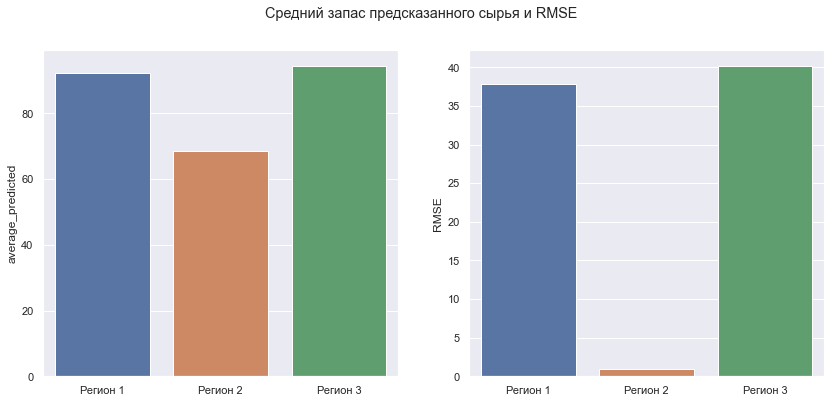

In [14]:
# делаем таблицу для графиков
reserve = {'region' : ['Регион 1', 'Регион 2','Регион 3'],
           'average_predicted' : [geo_1['prediction'].mean(), geo_2['prediction'].mean(), geo_3['prediction'].mean()],
           'RMSE' : [37.85, 0.9, 40.21]
           }
reserve = pd.DataFrame(reserve).set_index('region')
display(round(reserve, 2))
# строим графики
sb.set_theme(style='darkgrid')
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
for i, ax in zip(reserve.columns, ax):
    sb.barplot(data=reserve, x=reserve.index, y=reserve[i], ax=ax);
    ax.set(xlabel=' ')
fig.suptitle('Средний запас предсказанного сырья и RMSE');

**Вывод**

Средний запас предсказанного сырья и RMSE по регионам (тыс. баррелей):

   - первый регион 92.42, RMSE 37.85 
   - второй регион 68.70,  RMSE 0.9 
   - третий регион 94.54,  RMSE 40.21
    
Предсказанные запасы в первом и третьем регоне примерно на четверть выше, чем во втором. Вторая модели предсказывает значения заметно точнее.
  
Все модели прошли проверку на адекватность

## Подготовка к расчёту прибыли

In [15]:
# посчитаем средний обём нефти в скавжине, исходя из бюджета и 200 точек
break_even = (REGION_BUDGET / INCOME_ONE_UNIT) / MODEL_RESEARCH
print('Достаточный объём сырья для безубыточной разработки новой скважины =', round(break_even, 2), '(тыс.баррелей)')
# считаем разницу объёмов для безубыточности по региону
for i, j in zip(reserve['average_predicted'], reserve.index):
    if break_even < i:
        print('Средний объем запасов одной скважины в', j, 'больше на',\
              round(i - break_even, 2), '(тыс.баррелей)')
    else:
        print('Средний объем запасов одной скважины в', j, 'меньше на',\
              round(break_even - i, 2), '(тыс.баррелей)')

Достаточный объём сырья для безубыточной разработки новой скважины = 111.11 (тыс.баррелей)
Средний объем запасов одной скважины в Регион 1 меньше на 18.69 (тыс.баррелей)
Средний объем запасов одной скважины в Регион 2 меньше на 42.41 (тыс.баррелей)
Средний объем запасов одной скважины в Регион 3 меньше на 16.57 (тыс.баррелей)


Средние запасы в регоне ниже, чем достаточный объём сырья для безубыточной разработки новой скважины. Этот происходит в следствии того, что у всех регионов есть скважены с низким объемом запасов. Далее рассмотрим 200 свкажин с наибольшими предсказаниями запасов и проверим долтаточный объём в них.

In [16]:
# считаем разницу объёмов для лучших 200 скважин в каждом регионе
for i, j in zip([geo_1, geo_2, geo_3], reserve.index):
    i = i.sort_values(by='prediction', ascending=False).head(MODEL_RESEARCH)
    if break_even < i['prediction'].mean():
        print('Средний объем запасов одной скважины в', j, 'больше на',\
              round(i['prediction'].mean() - break_even, 2), '(тыс.баррелей)')
    else:
        print('Средний объем запасов одной скважины в', j, 'меньше на',\
              round(break_even - i['prediction'].mean(), 2), '(тыс.баррелей)')

Средний объем запасов одной скважины в Регион 1 больше на 41.65 (тыс.баррелей)
Средний объем запасов одной скважины в Регион 2 больше на 27.99 (тыс.баррелей)
Средний объем запасов одной скважины в Регион 3 больше на 29.91 (тыс.баррелей)


**Вывод**

Во всех регионах есть по 200 точек, для безубыточной добычи. Лидирует **первый** регион:

- **Средний объем запасов одной скважины в Регион 1 больше на 52.38 (тыс.баррелей)**
- Средний объем запасов одной скважины в Регион 2 больше на 28.11 (тыс.баррелей)
- Средний объем запасов одной скважины в Регион 3 больше на 45.61 (тыс.баррелей)

## Расчёт прибыли и рисков 

In [17]:
# функция подсчёта прибыли для региона
def calculation_profit(df):
    summ = df.head(MODEL_RESEARCH)
    profit = sum(summ) * INCOME_ONE_UNIT - REGION_BUDGET
    return profit

In [29]:
# создаём объект RandomState для формирования выборок
STATE = np.random.RandomState(125)
# считаем среднюю выручку, интервал и процент риска для каждого региона
for j in tqdm([geo_1, geo_2, geo_3]):
    values = []
    loss =  0
    # Bootstrap
    for i in range(1000):
        # выбираем 500 строчек из таблицы
        target_sample = j['product'].sample(n=QUANTITY_RESEARCH, replace=True, random_state=STATE)
        # выбираем соответствующие 500 запасов сырья
        prediction_sample = j['prediction'].loc[target_sample.index].sort_values(ascending=False)
        # считаем доход
        profit = calculation_profit(target_sample[prediction_sample.index])
        values.append(profit)
        # ситаем случаи убытков
        if profit < 0:
            loss += 1
    # вывод значений
    values = pd.Series(values)
    mean = int(values.mean())
    print("Средняя выручка:", mean)
    lower = int(values.quantile(0.025))
    upper = int(values.quantile(0.975))
    print('95% доверительный интервал от', lower, 'до', upper)
    print('уровень риска', round(loss / 1000 * 100, 3), '%')

 33%|███████████████                              | 1/3 [00:00<00:01,  1.11it/s]

Средняя выручка: 388200343
95% доверительный интервал от -119340632 до 914257614
уровень риска 6.9 %


 67%|██████████████████████████████               | 2/3 [00:01<00:00,  1.08it/s]

Средняя выручка: 457288604
95% доверительный интервал от 68073957 до 859442434
уровень риска 1.0 %


100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.06it/s]

Средняя выручка: 261761340
95% доверительный интервал от -305698194 до 769908024
уровень риска 16.3 %


# Вывод

В ходе исследования были созданы 3 модели, по одной для каждого региона. Модели прошли проверку на адекватность и предсказали данные объёмов по все трё регионам. В точности лидирует модель по второму региону, её погрешность предсказания составила 0, 89 тыс. барелей.

Средний запас предсказанного сырья и RMSE по регионам (тыс. баррелей):

- Первый регион 92.42
- Второй регион 68.70
- Третий регион 94.54

Во всех регионах есть по 200 точек, для безубыточной добычи. По средему объёму запасов одной скважины лидирует **первый** регион:


Я рекомендую **второй** регион, т к в нем cредняя выручка 457 288 604 руб., 95% доверительный интервал от 68 073 957 до 859 442 434, уровень риска 1.0 %, что ниже минимального прога риска. Остальные регионы менее прибыльны и более рискованные.

## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнен шаг 1: данные подготовлены
- [x]  Выполнен шаг 2: модели обучены и проверены
    - [x]  Данные корректно разбиты на обучающую и валидационную выборки
    - [x]  Модели обучены, предсказания сделаны
    - [x]  Предсказания и правильные ответы на валидационной выборке сохранены
    - [x]  На экране напечатаны результаты
    - [x]  Сделаны выводы
- [x]  Выполнен шаг 3: проведена подготовка к расчёту прибыли
    - [x]  Для всех ключевых значений созданы константы Python
    - [x]  Посчитано минимальное среднее количество продукта в месторождениях региона, достаточное для разработки
    - [x]  По предыдущему пункту сделаны выводы
    - [x]  Написана функция расчёта прибыли
- [x]  Выполнен шаг 4: посчитаны риски и прибыль
    - [x]  Проведена процедура *Bootstrap*
    - [x]  Все параметры бутстрепа соответствуют условию
    - [x]  Найдены все нужные величины
    - [x]  Предложен регион для разработки месторождения
    - [x]  Выбор региона обоснован